# Project: Gesture Recognition for Smart TVs

## Overview
As a data scientist at a leading home electronics company, the task is to enhance the functionality of smart TVs by implementing a gesture recognition feature. This feature will allow users to control the TV using hand gestures, eliminating the need for a remote control.

## Problem Statement
The objective is to develop a system that can recognize five different gestures performed by the user using the webcam mounted on the TV. Each gesture corresponds to a specific action:

| Gesture | Action |
| --- | --- |
| Thumbs Up | Increase volume |
| Thumbs Down | Decrease volume |
| Left Swipe | Jump backward 10 seconds |
| Right Swipe | Jump forward 10 seconds |
| Stop | Pause the movie |

Each gesture is captured as a sequence of 30 frames (images).

## Objectives
1. **Generator**: Develop a generator capable of processing batches of videos seamlessly. This includes tasks such as cropping, resizing, and normalization.
2. **Model**: Design and train a model with a focus on minimizing the number of parameters to ensure efficient inference time while achieving high accuracy. Begin training with a small dataset and scale up as needed.
3. **Documentation**: Create a detailed write-up outlining the model selection process. This should include the rationale behind choosing the base model, as well as the experimentation and modifications made to arrive at the final model.


# Import Library

In [1]:
!pip install imageio scikit-image
!pip install opencv-python
!pip install matplotlib


## Mount Googl drive
* to import project_data

In [2]:
from google.colab import drive
import os
import zipfile

drive.mount('/content/drive')

Mounted at /content/drive


# Function Definitions

In [3]:
# import project_data.zip from google drive path and unzip

# Define the file path on Google Drive
file_path = "/content/drive/MyDrive/gesture-recognition-apr-2024/Project_data.zip"

# Check if the file exists
if os.path.exists(file_path):
    print(f"File {file_path} exists. Unzipping...")
    # Unzip the file
    with zipfile.ZipFile(file_path, 'r') as zip_ref:
        zip_ref.extractall('/content')
    print("Unzipping completed.")
else:
    print(f"File {file_path} does not exist.")

File /content/drive/MyDrive/gesture-recognition-apr-2024/Project_data.zip exists. Unzipping...
Unzipping completed.


In [8]:
# Standard library imports for file and directory handling, warnings, and timestamps
import datetime
import os
import pathlib
import warnings
from sys import getsizeof

# Third-party imports for data processing and random seed
import cv2
import matplotlib.pyplot as plt
import numpy as np
from imageio import imread
from skimage.transform import resize

# TensorFlow and Keras imports for model building and training
import tensorflow as tf
from tensorflow.keras import backend as K, optimizers
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import (Activation, BatchNormalization, Conv2D,
                                     Conv3D, Dense, Dropout, Flatten, GRU,
                                     LSTM, MaxPooling2D, MaxPooling3D,
                                     TimeDistributed)
from tensorflow.keras.models import Model, Sequential

# Set random seeds for reproducibility
np.random.seed(30)
rn.seed(30)
tf.random.set_seed(30)

# Ignore warnings
warnings.filterwarnings("ignore")

In [6]:
def load_data(is_colab):
    # Define the file paths

    if is_colab:
        train_path = "/content/Project_data/train.csv"
        val_path = "/content/Project_data/val.csv"
        project_folder = "/content/Project_data"
    else:
        train_path = "C:/Users/writi/Downloads/Project_data/Project_data/train.csv"
        val_path = "C:/Users/writi/Downloads/Project_data/Project_data/val.csv"
        project_folder = "C:/Users/writi/Downloads/Project_data/Project_data"

    train_doc = np.random.permutation(open(train_path).readlines())
    val_doc = np.random.permutation(open(val_path).readlines())
    batch_size = 30

    return project_folder, train_doc, val_doc, batch_size

In [7]:
project_folder, train_doc, val_doc, batch_size = load_data(True)  # if on Colab
# or
# project_folder, train_doc, val_doc, batch_size = load_data(False)  # if on local machine

In [10]:
#comparing training and validation plots
def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

In [11]:
def plot_v2(history):
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15,15))

    # Plotting loss
    axes[0].plot(history.history['loss'], color='orange')
    axes[0].plot(history.history['val_loss'], color='red')
    axes[0].legend(['loss','val_loss'])
    axes[0].set_title('Loss vs. epochs')
    axes[0].set_ylabel('Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].grid(True)

    # Plotting accuracy
    axes[1].plot(history.history['categorical_accuracy'], color='green')
    axes[1].plot(history.history['val_categorical_accuracy'], color='blue')
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])
    axes[1].set_title('Accuracy vs. epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].grid(True)

# Building Generators

## ModelBuilder Extension

In [42]:
class TimeHistory(Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

class CustomModelCheckpoint(ModelCheckpoint):
    def __init__(self, *args, **kwargs):
        super(CustomModelCheckpoint, self).__init__(*args, **kwargs)
        self.filepaths = []

    def on_epoch_end(self, epoch, logs=None):
        super().on_epoch_end(epoch, logs)
        self.filepaths.append(self.filepath.format(epoch=epoch+1, **logs))

# Base Model Builder

In [16]:

class ModelBuilder(metaclass= abc.ABCMeta):
    #project data path initialized
    def initialize_path(self,project_folder):
        self.train_doc = np.random.permutation(open(project_folder + '/' + 'train.csv').readlines())
        self.val_doc = np.random.permutation(open(project_folder + '/' + 'val.csv').readlines())
        self.train_path = project_folder + '/' + 'train'
        self.val_path =  project_folder + '/' + 'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)
    #image properties intialized
    def initialize_image_properties(self,image_height=100,image_width=100):
        self.image_height=image_height
        self.image_width=image_width
        self.channels=3
        self.num_classes=5
        self.total_frames=30
   #hyperparameters like batch size, frame to sample, total epochs defined
    def initialize_hyperparams(self,frames_to_sample=30,batch_size=20,num_epochs=20):
        self.frames_to_sample=frames_to_sample
        self.batch_size=batch_size
        self.num_epochs=num_epochs

    #generatori function
    def generator(self,source_path, folder_list, augment=False):
        img_idx = np.round(np.linspace(0,self.total_frames-1,self.frames_to_sample)).astype(int)
        batch_size=self.batch_size
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t)//batch_size

            for batch in range(num_batches):
                batch_data, batch_labels= self.one_batch_data(source_path,t,batch,batch_size,img_idx,augment)
                yield batch_data, batch_labels

            remaining_seq=len(t)%batch_size

            if (remaining_seq != 0):
                batch_data, batch_labels= self.one_batch_data(source_path,t,num_batches,batch_size,img_idx,augment,remaining_seq)
                yield batch_data, batch_labels


    def one_batch_data(self,source_path,t,batch,batch_size,img_idx,augment,remaining_seq=0):

        seq_len = remaining_seq if remaining_seq else batch_size

        batch_data = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))
        batch_labels = np.zeros((seq_len,self.num_classes))

        if (augment): batch_data_aug = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))


        for folder in range(seq_len):
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0])
            for idx,item in enumerate(img_idx):
                #reading image and resizing it
                image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                image_resized=resize(image,(self.image_height,self.image_width,3))

                #normalizing each channel of the image
                batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255

                if (augment):
                    shifted = cv2.warpAffine(image,
                                             np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]),
                                            (image.shape[1], image.shape[0]))

                    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0)

                    cropped=shifted[x0:x1,y0:y1,:]

                    image_resized=resize(cropped,(self.image_height,self.image_width,3))

                    #shifted = cv2.warpAffine(image_resized,
                    #                        np.float32([[1, 0, np.random.randint(-3,3)],[0, 1, np.random.randint(-3,3)]]),
                    #                        (image_resized.shape[1], image_resized.shape[0]))

                    batch_data_aug[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                    batch_data_aug[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                    batch_data_aug[folder,idx,:,:,2] = (image_resized[:,:,2])/255


            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1


        if (augment):
            batch_data=np.concatenate([batch_data,batch_data_aug])
            batch_labels=np.concatenate([batch_labels,batch_labels])


        return(batch_data,batch_labels)


    def train_model(self, model, augment_data=False):
        train_generator = self.generator(self.train_path, self.train_doc,augment=augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)

        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'

        if not os.path.exists(model_name):
            os.mkdir(model_name)

        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        callbacks_list = [checkpoint, LR]

        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1

        history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, initial_epoch=0)

        return history


    @abc.abstractmethod
    def define_model(self):
        pass

Building models
* We are going to use Conv3D and Maxpooling3D and not Conv2D and Maxpooling2D for a 3D convulation. We can use TimeDistributed while building a Conv2D+RNN model. Last layers is to be softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

Sample Model

In [ ]:
class ModelConv3D1(ModelBuilder):

    def define_model(self):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))#to avoid reducing the image by half everytime

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(128,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        model.add(Dense(64,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.25))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        #optimiser = 'sgd'
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

### Model Validation for quick sanity

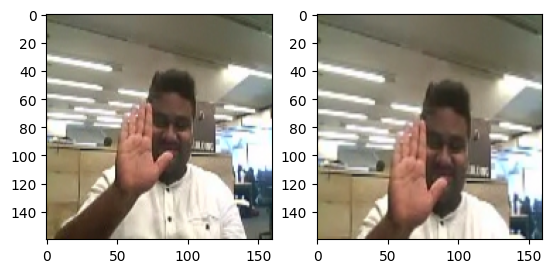

In [ ]:
# Initialize the model and set the path and image properties
test_generator = ModelConv3D1()
test_generator.initialize_path(project_folder)
test_generator.initialize_image_properties(image_height=160, image_width=160)

# Set the hyperparameters
test_generator.initialize_hyperparams(frames_to_sample=30, batch_size=3, num_epochs=1)

# Generate the data
g = test_generator.generator(test_generator.val_path, test_generator.val_doc, augment=True)

# Get the next batch of data and labels
batch_data, batch_labels = next(g)

# Plot the 15th frame of the first and fourth video in the batch
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(batch_data[0, 15, :, :, :])
axes[1].imshow(batch_data[3, 15, :, :, :])

### Modle setup and parameters testing





* Experimenting with Image resolution, number of frames to use and batch_size

Model Name: conv_3d1

Path Initialization: The model is initialized with a project folder path provided by the project_folder variable.

Image Properties: The model uses images of resolution 160x160. This means that each input image is resized to 160 pixels in height and 160 pixels in width.

Hyperparameters: The model has been initialized with the following hyperparameters:

frames_to_sample: 30. This means that 30 frames are sampled from each video for the model training.
batch_size: 10. This is the number of samples processed before the model is updated. The number of epochs is the number of complete passes through the training dataset.
num_epochs: 1. This is the number of complete passes through the training dataset.
Model Definition: The model is defined by the define_model method of the ModelConv3D1 class. The details of the model architecture can be viewed using the summary method.

Please note that the actual architecture of the model (number of layers, types of layers, etc.) is not specified in the provided code. You can see the architecture by calling conv_3d1_model.summary().


In [ ]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=10,num_epochs=1)
conv_3d1_model=conv_3d1.define_model()
conv_3d1_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 30, 160, 160, 16)  1312      
                                                                 
 activation (Activation)     (None, 30, 160, 160, 16)  0         
                                                                 
 batch_normalization (BatchN  (None, 30, 160, 160, 16)  64       
 ormalization)                                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 15, 80, 80, 16)   0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 15, 80, 80, 32)    4128      
                                                                 
 activation_1 (Activation)   (None, 15, 80, 80, 32)    0

In [ ]:
conv_3d1.train_model(conv_3d1_model)

ResourceExhaustedError: Graph execution error:

Detected at node 'sequential/batch_normalization/FusedBatchNormV3' defined at (most recent call last):
    File "C:\Users\writi\miniconda3\envs\tf\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\writi\miniconda3\envs\tf\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\Users\writi\miniconda3\envs\tf\lib\site-packages\ipykernel_launcher.py", line 18, in <module>
      app.launch_new_instance()
    File "C:\Users\writi\miniconda3\envs\tf\lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
      app.start()
    File "C:\Users\writi\miniconda3\envs\tf\lib\site-packages\ipykernel\kernelapp.py", line 739, in start
      self.io_loop.start()
    File "C:\Users\writi\miniconda3\envs\tf\lib\site-packages\tornado\platform\asyncio.py", line 205, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\writi\miniconda3\envs\tf\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "C:\Users\writi\miniconda3\envs\tf\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "C:\Users\writi\miniconda3\envs\tf\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\writi\miniconda3\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue
      await self.process_one()
    File "C:\Users\writi\miniconda3\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 534, in process_one
      await dispatch(*args)
    File "C:\Users\writi\miniconda3\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell
      await result
    File "C:\Users\writi\miniconda3\envs\tf\lib\site-packages\ipykernel\ipkernel.py", line 362, in execute_request
      await super().execute_request(stream, ident, parent)
    File "C:\Users\writi\miniconda3\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 778, in execute_request
      reply_content = await reply_content
    File "C:\Users\writi\miniconda3\envs\tf\lib\site-packages\ipykernel\ipkernel.py", line 449, in do_execute
      res = shell.run_cell(
    File "C:\Users\writi\miniconda3\envs\tf\lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\writi\miniconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3048, in run_cell
      result = self._run_cell(
    File "C:\Users\writi\miniconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3103, in _run_cell
      result = runner(coro)
    File "C:\Users\writi\miniconda3\envs\tf\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\writi\miniconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3308, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\writi\miniconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3490, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\writi\miniconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3550, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\writi\AppData\Local\Temp\ipykernel_21356\1646665663.py", line 1, in <module>
      conv_3d1.train_model(conv_3d1_model)
    File "C:\Users\writi\AppData\Local\Temp\ipykernel_21356\1908022087.py", line 124, in train_model
      history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1,
    File "C:\Users\writi\miniconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\writi\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\writi\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "C:\Users\writi\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\writi\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "C:\Users\writi\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 993, in train_step
      y_pred = self(x, training=True)
    File "C:\Users\writi\miniconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\writi\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "C:\Users\writi\miniconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\writi\miniconda3\envs\tf\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\writi\miniconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\writi\miniconda3\envs\tf\lib\site-packages\keras\engine\sequential.py", line 410, in call
      return super().call(inputs, training=training, mask=mask)
    File "C:\Users\writi\miniconda3\envs\tf\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "C:\Users\writi\miniconda3\envs\tf\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\Users\writi\miniconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\writi\miniconda3\envs\tf\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\writi\miniconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\writi\miniconda3\envs\tf\lib\site-packages\keras\layers\normalization\batch_normalization.py", line 850, in call
      outputs = self._fused_batch_norm(inputs, training=training)
    File "C:\Users\writi\miniconda3\envs\tf\lib\site-packages\keras\layers\normalization\batch_normalization.py", line 660, in _fused_batch_norm
      output, mean, variance = control_flow_util.smart_cond(
    File "C:\Users\writi\miniconda3\envs\tf\lib\site-packages\keras\utils\control_flow_util.py", line 108, in smart_cond
      return tf.__internal__.smart_cond.smart_cond(
    File "C:\Users\writi\miniconda3\envs\tf\lib\site-packages\keras\layers\normalization\batch_normalization.py", line 634, in _fused_batch_norm_training
      return tf.compat.v1.nn.fused_batch_norm(
Node: 'sequential/batch_normalization/FusedBatchNormV3'
OOM when allocating tensor with shape[10,16,30,25600] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node sequential/batch_normalization/FusedBatchNormV3}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_2257]

In [ ]:
print("Memory util is {} Gigs". format(getsizeof(np.zeros((40,16,30,160,160)))/(1024*1024*1024)))

Memory util is 3.662109538912773 Gigs


The ResourceExhaustedError you’re encountering typically indicates that the operation being performed is trying to use more memory than is available in your environment. In the context of training a model with TensorFlow, this error usually means that the model is too large for the GPU or CPU memory.

The error occurs during the model.fit call, which suggests that the training process requires more memory than is available. To resolve this issue, you can try the following steps:

Reduce the batch size: Smaller batches require less memory and can help avoid this error.
Simplify the model: Reducing the complexity of the model can also reduce memory usage.


In [ ]:
#Sample model 2: Reducing Frames_to_sample: 15 and image size to 100X100, batch_size is 10.

conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=100,image_width=100)
conv_3d1.initialize_hyperparams(frames_to_sample=15,batch_size=10,num_epochs=1)
conv_3d1_model=conv_3d1.define_model()
conv_3d1_model.summary()
print("Total Params:", conv_3d1_model.count_params())


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 15, 100, 100, 16)  1312      
                                                                 
 activation_4 (Activation)   (None, 15, 100, 100, 16)  0         
                                                                 
 batch_normalization_6 (Batc  (None, 15, 100, 100, 16)  64       
 hNormalization)                                                 
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 8, 50, 50, 16)    0         
 3D)                                                             
                                                                 
 conv3d_5 (Conv3D)           (None, 8, 50, 50, 32)     4128      
                                                                 
 activation_5 (Activation)   (None, 8, 50, 50, 32)    

In [ ]:
conv_3d1.train_model(conv_3d1_model)

67/67 [==============================] - ETA: 0s - loss: 1.5305 - categorical_accuracy: 0.4374
Epoch 1: saving model to model_init_2024-04-0903_29_51.064255\model-00001-1.53053-0.43741-2.12857-0.18000.keras
67/67 [==============================] - 68s 985ms/step - loss: 1.5305 - categorical_accuracy: 0.4374 - val_loss: 2.1286 - val_categorical_accuracy: 0.1800 - lr: 0.0010


Successful Run compared to the sample run#1

Steps: 67/67
Time per Step: 985ms/step
Training Loss: 1.5305
Training Categorical Accuracy: 43.74%
Validation Loss: 2.1286
Validation Categorical Accuracy: 18.00%
Learning Rate: 0.0010

In [ ]:
#Sample model 2: reduced the image size to 100X100, frame_to_sample = 15 and batch_size to 20
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=100,image_width=100)
conv_3d1.initialize_hyperparams(frames_to_sample=15,batch_size=20,num_epochs=1)
conv_3d1_model=conv_3d1.define_model()
conv_3d1_model.summary()
print("Total Params:", conv_3d1_model.count_params())


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_12 (Conv3D)          (None, 15, 100, 100, 16)  1312      
                                                                 
 activation_12 (Activation)  (None, 15, 100, 100, 16)  0         
                                                                 
 batch_normalization_18 (Bat  (None, 15, 100, 100, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_12 (MaxPoolin  (None, 8, 50, 50, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_13 (Conv3D)          (None, 8, 50, 50, 32)     4128      
                                                                 
 activation_13 (Activation)  (None, 8, 50, 50, 32)    

In [ ]:
conv_3d1.train_model(conv_3d1_model)

34/34 [==============================] - ETA: 0s - loss: 1.5344 - categorical_accuracy: 0.4434
Epoch 1: saving model to model_init_2024-04-0903_34_10.583489\model-00001-1.53440-0.44344-1.78991-0.24000.keras
34/34 [==============================] - 64s 2s/step - loss: 1.5344 - categorical_accuracy: 0.4434 - val_loss: 1.7899 - val_categorical_accuracy: 0.2400 - lr: 0.0010


Second Run Summary:

Total Steps: 34/34
Training Loss: 1.5344
Training Categorical Accuracy: 44.34%
Validation Loss: 1.7899
Validation Categorical Accuracy: 24.00%
Learning Rate: 0.0010
Time per Step: 2s/step
Total Time: 64 seconds

Differences:

The second summary shows a slightly higher training accuracy and a significantly higher validation accuracy compared to the first summary.
The validation loss in the second summary is lower, indicating better generalization on the validation set.
The time per step is longer in the second summary, which could be due to a more complex model or larger batch size.
The total number of steps is half in the second summary, suggesting a smaller dataset or a larger batch size.

## Model 1
- Layer construction:
  - Input Layer
  - Conv3D Layer 1
  - Conv3D Layer 2
  - Conv3D Layer 3
  - Conv3D Layer 4
  - Flatten Layer
  - Dense Layer 1
  - Dense Layer 2
  - Output Layer
- filter size (3,3,3)
- dense neurons = 64
- dropout = 0.25

The model uses the Adam optimizer and the categorical cross-entropy loss function.

In [ ]:
class ModelConv3D1(ModelBuilder):

    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))#to avoid reducing the image by half everytime

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))#to avoid reducing the image by half everytime

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(128,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(64,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

Starting with
- image size = 120X120
- frames to sample = 15
- Batch size = 20
- No.of epochs = 15


In [ ]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=100,image_width=100)
conv_3d1.initialize_hyperparams(frames_to_sample=15,batch_size=20,num_epochs=15)
conv_3d1_model=conv_3d1.define_model()
conv_3d1_model.summary()



Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_24 (Conv3D)          (None, 15, 100, 100, 16)  1312      
                                                                 
 activation_24 (Activation)  (None, 15, 100, 100, 16)  0         
                                                                 
 batch_normalization_32 (Bat  (None, 15, 100, 100, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_24 (MaxPoolin  (None, 8, 50, 50, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_25 (Conv3D)          (None, 8, 50, 50, 32)     13856     
                                                                 
 activation_25 (Activation)  (None, 8, 50, 50, 32)    

In [ ]:
print("Total Params:", conv_3d1_model.count_params())
history_model1 = conv_3d1.train_model(conv_3d1_model)

Total Params: 892101
Epoch 1/15
34/34 [==============================] - ETA: 0s - loss: 1.3751 - categorical_accuracy: 0.4857
Epoch 1: saving model to model_init_2024-04-0903_42_05.879199\model-00001-1.37507-0.48567-4.27814-0.16000.keras
34/34 [==============================] - 64s 2s/step - loss: 1.3751 - categorical_accuracy: 0.4857 - val_loss: 4.2781 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/15
33/34 [============================>.] - ETA: 1s - loss: 0.8747 - categorical_accuracy: 0.6773
Epoch 2: saving model to model_init_2024-04-0903_42_05.879199\model-00002-0.87142-0.67873-3.48896-0.16000.keras
34/34 [==============================] - 64s 2s/step - loss: 0.8714 - categorical_accuracy: 0.6787 - val_loss: 3.4890 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 3/15
34/34 [==============================] - ETA: 0s - loss: 0.5725 - categorical_accuracy: 0.7964
Epoch 3: saving model to model_init_2024-04-0903_42_05.879199\model-00003-0.57254-0.79638-3.41942-0.16000

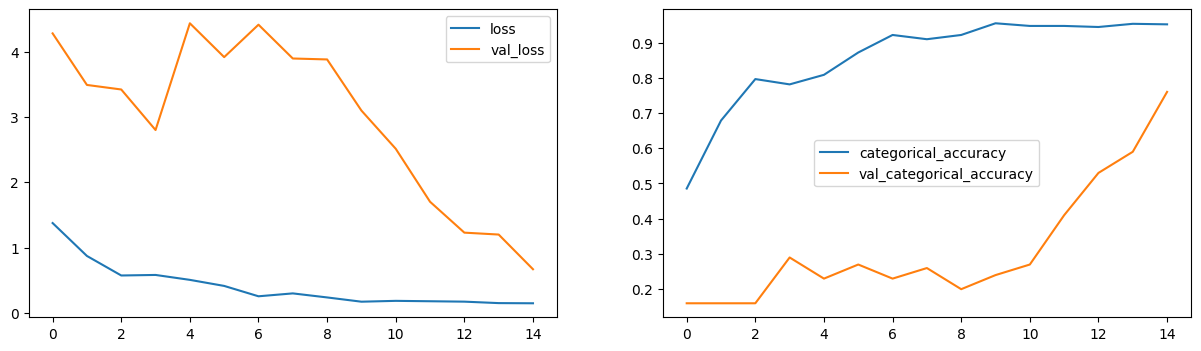

In [ ]:
plot(history_model1)

#### Interpretation on Model 1

Loss and Validation Loss (Left Graph):

Loss (Blue Line): Starts just below 4 and sharply decreases to close to 1 by epoch 6, then slightly increases, indicating initial learning and slight overfitting as training progresses.
Validation Loss (Orange Line): Begins just above 3, peaks around epoch 4, then steadily decreases, suggesting the model is starting to generalize better after initial epochs.

Categorical Accuracy and Validation Categorical Accuracy (Right Graph):
Categorical Accuracy (Blue Line): Starts at approximately 0.2 and steadily increases, stabilizing around 0.8 after epoch 10, showing consistent learning and improvement in classifying training data.
Validation Categorical Accuracy (Orange Line): Begins near 0.3, peaks close to epoch 4 at about 0.55, then fluctuates before stabilizing around 0.5 after epoch 10, indicating some variability in the model’s performance on unseen data.

Overall, these graphs suggest that the model is learning and improving its performance on the training data while also showing signs of generalizing to validation data. However, the slight increase in loss after epoch 6 and the fluctuations in validation accuracy indicate that there might be room for optimization, possibly by adjusting hyperparameters like learning rate or by implementing regularization techniques to combat overfitting

## Model 2
- Layer construction:
  - Input Layer
  - Conv3D Layer 1
  - Conv3D Layer 2
  - Conv3D Layer 3
  - Conv3D Layer 4
  - Flatten Layer
  - Dense Layer 1
  - Dense Layer 2
  - Output Layer
- filter size (3,3,3)
- dense neurons = 256
- dropout set to 0.5
- batchsize reduced to 10 to avoid resource exhausion

In [ ]:
conv_3d2=ModelConv3D1()
conv_3d2.initialize_path(project_folder)
conv_3d2.initialize_image_properties(image_height=100,image_width=100)
conv_3d2.initialize_hyperparams(frames_to_sample=15,batch_size=10,num_epochs=25)
conv_3d2_model=conv_3d2.define_model(dense_neurons=256,dropout=0.5)
conv_3d2_model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_48 (Conv3D)          (None, 15, 100, 100, 16)  1312      
                                                                 
 activation_48 (Activation)  (None, 15, 100, 100, 16)  0         
                                                                 
 batch_normalization_68 (Bat  (None, 15, 100, 100, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_48 (MaxPoolin  (None, 8, 50, 50, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_49 (Conv3D)          (None, 8, 50, 50, 32)     13856     
                                                                 
 activation_49 (Activation)  (None, 8, 50, 50, 32)   

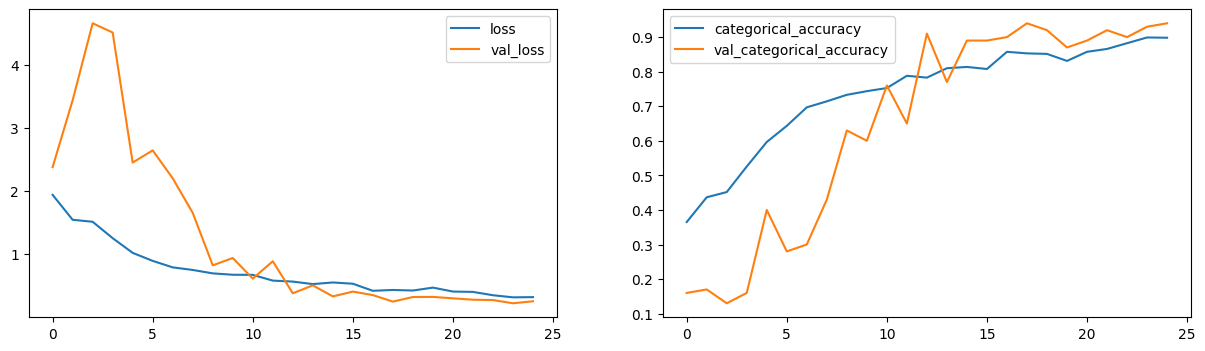

In [ ]:
plot(history_model2)

#### Interpretation on Model 2
The left graph illustrate the decrease in loss and the right graph illustrates increase in accuracy over time, which are indicative of effective learning. The fact that the validation metrics are better than the training metrics suggesting the model is generalizing well and clearly not overfitting.

For the next model, the objective is to reduce oscillating validation loss.


## Model 3
## Model 3
- Layer construction:
    - Input Layer
    - Conv3D Layer 1
    - Conv3D Layer 2
    - Conv3D Layer 3
    - Conv3D Layer 4
    - Flatten Layer
    - Dense Layer 1
    - Dense Layer 2
    - Output Layer
- filter size (3,3,3)
- dense neurons = 64
- dropout = 0.25
- learning rate = 0.0003
- This model is very similar to Model 1, but with a different learning rate for the Adam optimizer. The learning rate is set to 0.0003 in this model.

- filter size reduced to (2,2,2) will help bring more efficiency to the model
- Lowering learning rate to 0.0003 since loss is not reducing smoothly but fluctuating.



In [17]:
class ModelConv3D3(ModelBuilder):

    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2),padding='same'))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2),padding='same'))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0003)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [18]:
conv_3d3=ModelConv3D3()
conv_3d3.initialize_path(project_folder)
conv_3d3.initialize_image_properties(image_height=100,image_width=100)
conv_3d3.initialize_hyperparams(frames_to_sample=15,batch_size=10,num_epochs=30)
conv_3d3_model=conv_3d3.define_model(filtersize=(2,2,2),dense_neurons=256,dropout=0.5)
conv_3d3_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 15, 100, 100, 16   400       
                             )                                   
                                                                 
 activation (Activation)     (None, 15, 100, 100, 16   0         
                             )                                   
                                                                 
 batch_normalization (Batch  (None, 15, 100, 100, 16   64        
 Normalization)              )                                   
                                                                 
 max_pooling3d (MaxPooling3  (None, 8, 50, 50, 16)     0         
 D)                                                              
                                                                 
 conv3d_1 (Conv3D)           (None, 8, 50, 50, 32)     4

In [ ]:
print("Total Params:", conv_3d3_model.count_params())
history_model3=conv_3d3.train_model(conv_3d3_model,augment_data=True)

Total Params: 1336629
Epoch 1/30
67/67 [==============================] - ETA: 0s - loss: 1.9501 - categorical_accuracy: 0.3846
Epoch 1: saving model to model_init_2024-04-0912_12_41.843032\model-00001-1.95013-0.38462-3.05975-0.16000.h5
67/67 [==============================] - 128s 2s/step - loss: 1.9501 - categorical_accuracy: 0.3846 - val_loss: 3.0598 - val_categorical_accuracy: 0.1600 - lr: 3.0000e-04
Epoch 2/30
67/67 [==============================] - ETA: 0s - loss: 1.3410 - categorical_accuracy: 0.5294
Epoch 2: saving model to model_init_2024-04-0912_12_41.843032\model-00002-1.34102-0.52941-5.50381-0.16000.h5
67/67 [==============================] - 112s 2s/step - loss: 1.3410 - categorical_accuracy: 0.5294 - val_loss: 5.5038 - val_categorical_accuracy: 0.1600 - lr: 3.0000e-04
Epoch 3/30
67/67 [==============================] - ETA: 0s - loss: 1.1610 - categorical_accuracy: 0.5724
Epoch 3: saving model to model_init_2024-04-0912_12_41.843032\model-00003-1.16100-0.57240-7.15091-0.

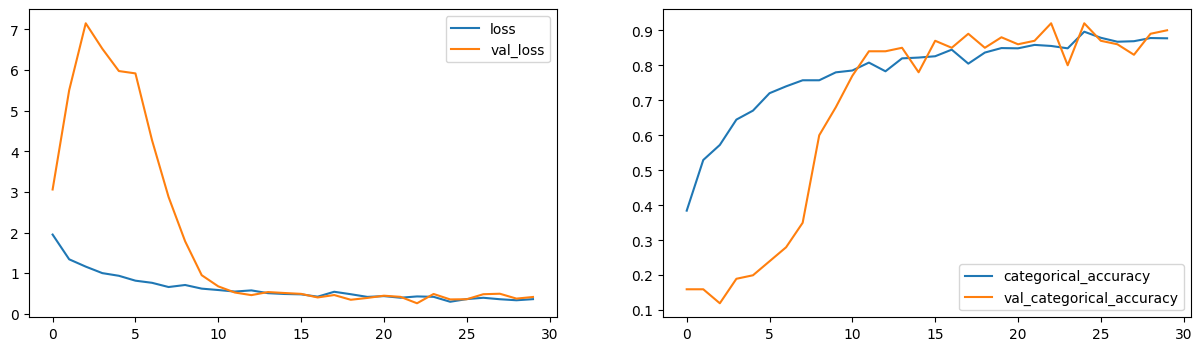

In [ ]:
plot(history_model3)


##### Interpretation of Model 3

The performance of your model at epoch 30 indicates a good balance between learning from the training data and generalizing to the validation data. Here’s what the metrics tell us:

Training Loss (0.3604): The model’s average error per batch is relatively low, which means it’s learning effectively from the training data.
Training Categorical Accuracy (87.71%): This is a high accuracy rate, showing that the model is correctly classifying a large percentage of the training set.
Validation Loss (0.4137): The validation loss is slightly higher than the training loss, which is normal as the model is usually better at predicting data it has seen before.
Validation Categorical Accuracy (90.00%): The model has a high accuracy on the validation set, which suggests it should perform well on similar unseen data.
Learning Rate (1.2000e-05): The learning rate is quite low, which is typical towards the end of training to make smaller adjustments to the weights.

The hypothesis of keeping the smaller filter (2,2,2) and infinitesimal learning rante 0.0002 helps us reduce osciallating validation loss. Overall, the model seems to be performing well without overfitting, as indicated by the high validation accuracy.

For the next model, I would want to add more layers to architecture with a hypothesis that it would perform better on more complex validation data.

## Model 4
- Layer construction:
    - Input Layer
    - Conv3D Layer 1
    - Conv3D Layer 1 (doubled)
    - MaxPooling3D Layer 1
    - Dropout Layer 1
    - Conv3D Layer 2
    - Conv3D Layer 2 (doubled)
    - MaxPooling3D Layer 2
    - Dropout Layer 2
    - Conv3D Layer 3
    - Conv3D Layer 3 (doubled)
    - MaxPooling3D Layer 3
    - Dropout Layer 3
    - Conv3D Layer 4
    - Conv3D Layer 4 (doubled)
    - MaxPooling3D Layer 4
    - Dropout Layer 4
    - Flatten Layer
    - Dense Layer 1
    - Dropout Layer 5
    - Dense Layer 2
    - Dropout Layer 6
    - Output Layer
- filter size (3,3,3)
- dense neurons = 64
- dropout = 0.25
- This model is similar to the previous models, increase the number of convulution layer i.e each Conv3D layer is doubled before a max pooling layer. This means that there are two Conv3D layers with the same number of filters and filter size, followed by a ReLU activation and batch normalization, before max pooling is applied. This is done for the first four sets of Conv3D layers. The model uses the Adam optimizer with the default learning rate.

- Adding more layers to potentially capture more complex patterns that will help us future proofing the model to generalize more complex data. However, this comes at cost of causing overfitting. We would use dropout layers in combination to randomnly drop neurons during training to prevent complex co-adaptations on training data.

- Keeping hyperparmeters
    - size is 100X100
    - frames to sample 15
    - reduced batch size to 8 to counter resource exhaustion error
    - num_epochs = 30
    - The learning rate is remains default to 0.01


In [ ]:
class ModelConv3D4(ModelBuilder):

    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        ##doubled layer
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(MaxPooling3D(pool_size=(2, 2, 2),padding='same'))
        model.add(Dropout(dropout))

        ##doubled layer
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        ##doubled layer
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(MaxPooling3D(pool_size=(2, 2, 2),padding='same'))
        model.add(Dropout(dropout))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        ##doubled layer
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:

conv_3d4=ModelConv3D4()
conv_3d4.initialize_path(project_folder)
conv_3d4.initialize_image_properties(image_height=100,image_width=100)
conv_3d4.initialize_hyperparams(frames_to_sample=15,batch_size=5,num_epochs=30)
conv_3d4_model=conv_3d4.define_model(dense_neurons=256,dropout=0.5)
conv_3d4_model.summary()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_136 (Conv3D)         (None, 15, 100, 100, 16)  1312      
                                                                 
 activation_136 (Activation)  (None, 15, 100, 100, 16)  0        
                                                                 
 batch_normalization_146 (Ba  (None, 15, 100, 100, 16)  64       
 tchNormalization)                                               
                                                                 
 conv3d_137 (Conv3D)         (None, 15, 100, 100, 16)  6928      
                                                                 
 activation_137 (Activation)  (None, 15, 100, 100, 16)  0        
                                                                 
 batch_normalization_147 (Ba  (None, 15, 100, 100, 16)  64       
 tchNormalization)                                   

In [ ]:
print("Total Params:", conv_3d4_model.count_params())
history_model4=conv_3d4.train_model(conv_3d4_model,augment_data=True)


Total Params: 2130549
Epoch 1/30
133/133 [==============================] - ETA: 0s - loss: 2.4161 - categorical_accuracy: 0.2353
Epoch 1: saving model to model_init_2024-04-0913_43_39.328391\model-00001-2.41614-0.23529-4.78018-0.18000.h5
133/133 [==============================] - 133s 955ms/step - loss: 2.4161 - categorical_accuracy: 0.2353 - val_loss: 4.7802 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 2/30
133/133 [==============================] - ETA: 0s - loss: 1.9857 - categorical_accuracy: 0.3115
Epoch 2: saving model to model_init_2024-04-0913_43_39.328391\model-00002-1.98570-0.31146-4.93109-0.27000.h5
133/133 [==============================] - 117s 885ms/step - loss: 1.9857 - categorical_accuracy: 0.3115 - val_loss: 4.9311 - val_categorical_accuracy: 0.2700 - lr: 0.0010
Epoch 3/30
133/133 [==============================] - ETA: 0s - loss: 1.7685 - categorical_accuracy: 0.3529
Epoch 3: saving model to model_init_2024-04-0913_43_39.328391\model-00003-1.76849-0.35294-6.

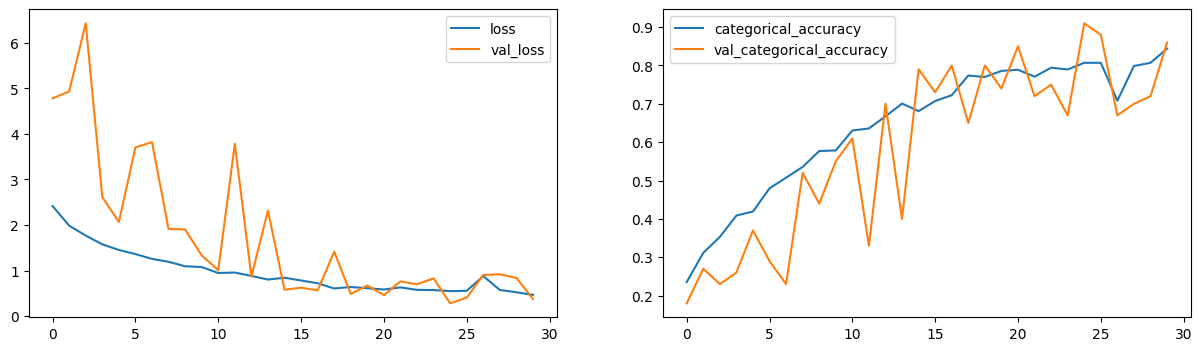

In [ ]:
plot(history_model4)

#### Intepretation of model 4

The validation

Due to addeed the convulational layers and dropouts layer only increased
- we increased complexity of the architecture
- resource consumption that often gave me memory exhaust error cause the numpy error that was being created to process each image was more than the total memory of my machine

This is not a great idea, so we take the model 3 again but reduce number of parameters to see if we can achieve the same level of learning.




## Model 5
- Layer construction:
    - Input Layer
    - Conv3D Layer 1
    - Conv3D Layer 1 (doubled)
    - MaxPooling3D Layer 1
    - Dropout Layer 1
    - Conv3D Layer 2
    - Conv3D Layer 2 (doubled)
    - MaxPooling3D Layer 2
    - Dropout Layer 2
    - Conv3D Layer 3
    - Conv3D Layer 3 (doubled)
    - MaxPooling3D Layer 3
    - Dropout Layer 3
    - Conv3D Layer 4
    - Conv3D Layer 4 (doubled)
    - MaxPooling3D Layer 4
    - Dropout Layer 4
    - Flatten Layer
    - Dense Layer 1
    - Dropout Layer 5
    - Dense Layer 2
    - Dropout Layer 6
    - Output Layer
- Filter size: (3,3,3)
- Dense neurons: 64
- Dropout: 0.25

This model is similar to the previous models, but with an increase in the number of convolution layers. Each Conv3D layer is doubled before a max pooling layer. This means that there are two Conv3D layers with the same number of filters and filter size, followed by a ReLU activation and batch normalization, before max pooling is applied. This is done for the first four sets of Conv3D layers. The model uses the Adam optimizer with the default learning rate.

Adding more layers potentially captures more complex patterns that will help future-proof the model to generalize more complex data. However, this comes at the cost of causing overfitting. Dropout layers are used in combination to randomly drop neurons during training to prevent complex co-adaptations on training data.

- Hyperparameters:
  - Image size: 100x100
  - Frames to sample: 15
  - Batch size: 8 (reduced to counter resource exhaustion error)
  - Number of epochs: 30
  - Learning rate: Default (0.01)

In [ ]:
class ModelConv3D5(ModelBuilder):
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(8, filtersize, padding='same', input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(16, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        if model.output_shape[1] > 1:
            model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        if model.output_shape[1] > 1:
            model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        if model.output_shape[1] > 1:
            model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        if model.output_shape[1] > 1:
            model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0003)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
conv_3d5=ModelConv3D5()
conv_3d5.initialize_path(project_folder)
conv_3d5.initialize_image_properties(image_height=100,image_width=100)
conv_3d5.initialize_hyperparams(frames_to_sample=15,batch_size=10,num_epochs=22)
conv_3d5_model=conv_3d5.define_model(dense_neurons=32,dropout=0.25)
conv_3d5_model.summary()

Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_177 (Conv3D)         (None, 15, 100, 100, 8)   656       
                                                                 
 activation_177 (Activation)  (None, 15, 100, 100, 8)  0         
                                                                 
 batch_normalization_189 (Ba  (None, 15, 100, 100, 8)  32        
 tchNormalization)                                               
                                                                 
 max_pooling3d_157 (MaxPooli  (None, 7, 50, 50, 8)     0         
 ng3D)                                                           
                                                                 
 conv3d_178 (Conv3D)         (None, 7, 50, 50, 16)     3472      
                                                                 
 activation_178 (Activation)  (None, 7, 50, 50, 16)  

In [ ]:
print("Total Params:", conv_3d5_model.count_params())
history_model5=conv_3d5.train_model(conv_3d5_model,augment_data=True)


Total Params: 444613
Epoch 1/22
67/67 [==============================] - ETA: 0s - loss: 1.6887 - categorical_accuracy: 0.3318
Epoch 1: saving model to model_init_2024-04-0916_01_59.475379\model-00001-1.68875-0.33183-2.33113-0.21000.h5
67/67 [==============================] - 128s 2s/step - loss: 1.6887 - categorical_accuracy: 0.3318 - val_loss: 2.3311 - val_categorical_accuracy: 0.2100 - lr: 3.0000e-04
Epoch 2/22
67/67 [==============================] - ETA: 0s - loss: 1.3357 - categorical_accuracy: 0.4449
Epoch 2: saving model to model_init_2024-04-0916_01_59.475379\model-00002-1.33572-0.44495-3.28934-0.21000.h5
67/67 [==============================] - 109s 2s/step - loss: 1.3357 - categorical_accuracy: 0.4449 - val_loss: 3.2893 - val_categorical_accuracy: 0.2100 - lr: 3.0000e-04
Epoch 3/22
67/67 [==============================] - ETA: 0s - loss: 1.1376 - categorical_accuracy: 0.5513
Epoch 3: saving model to model_init_2024-04-0916_01_59.475379\model-00003-1.13763-0.55128-3.56253-0.2

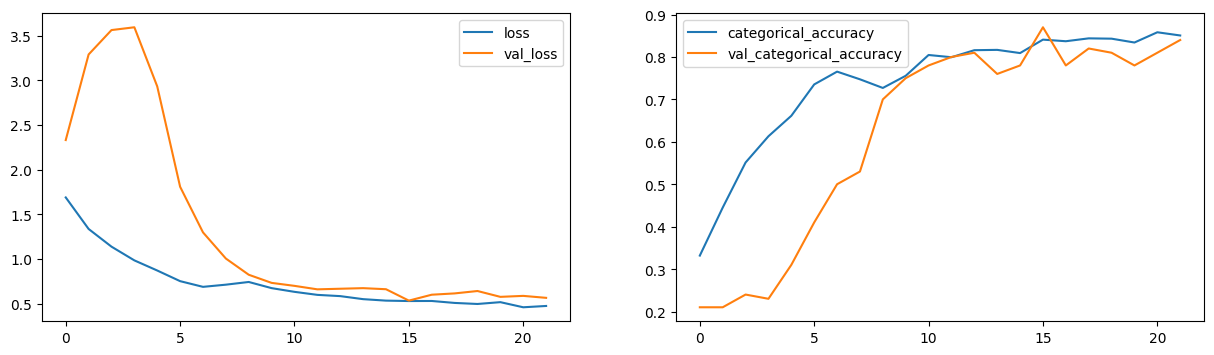

In [ ]:
plot(history_model5)

#### Interpretation of Model 5

The loss and accuracy graphs of model 3 and model 5 are almost identical. The model 5 gives similar output with lesser number of parameter.
Now the parameters have dramatically reduces to 450K.The performance comparison between Model 5 (at Epoch 22) and Model 3 (at Epoch 30):

Model 5 (Epoch 22):
Training Loss: 0.4736
Training Categorical Accuracy: 0.8507
Validation Loss: 0.5646
Validation Categorical Accuracy: 0.8400
Model 3 (Epoch 30):
Training Loss: 0.3604
Training Categorical Accuracy: 0.8771
Validation Loss: 0.4137
Validation Categorical Accuracy: 0.9000
Interpretation:

Both models show improvement during training (lower loss and higher accuracy).
Model 3 outperforms Model 5 in terms of both training and validation metrics.
Model 3 achieves higher accuracy on the validation set (90%) compared to Model 5 (84%).
Remember that lower loss and higher accuracy are desirable. Model 3 seems to generalize better to unseen data.

## Model 6
- Layer construction:
    - TimeDistributed Conv2D Layer 1
    - TimeDistributed BatchNormalization Layer 1
    - TimeDistributed MaxPooling2D Layer 1
    - TimeDistributed Conv2D Layer 2
    - TimeDistributed BatchNormalization Layer 2
    - TimeDistributed MaxPooling2D Layer 2
    - TimeDistributed Conv2D Layer 3
    - TimeDistributed BatchNormalization Layer 3
    - TimeDistributed MaxPooling2D Layer 3
    - TimeDistributed Conv2D Layer 4
    - TimeDistributed BatchNormalization Layer 4
    - TimeDistributed MaxPooling2D Layer 4
    - TimeDistributed Conv2D Layer 5
    - TimeDistributed BatchNormalization Layer 5
    - TimeDistributed MaxPooling2D Layer 5
    - TimeDistributed Flatten Layer
    - LSTM Layer
    - Dropout Layer 1
    - Dense Layer 1
    - Dropout Layer 2
    - Output Layer
- LSTM cells: 128
- Dense neurons: 128
- Dropout: 0.25

- This model is a combination of CNN and RNN layers. The CNN layers are used to extract spatial features and the LSTM layer is used to extract temporal features. The CNN layers are wrapped in TimeDistributed layers to allow the model to process each frame independently. The extracted features are then flattened and passed through an LSTM layer. The output of the LSTM layer is then passed through two dense layers with dropout in between for regularization.

- Hyperparameters:
  - Image size: 100x100
  - Frames to sample: 15
  - Batch size: 10
  - Number of epochs: 20
  - Learning rate: Default (0.01)

In [ ]:
class RNNCNN1(ModelBuilder):
  def define_model(self,lstm_cells=64, dense_neurons=64, dropout=0.25):
      model = Sequential()
      model.add(TimeDistributed(Conv2D(16, (3,3), padding='same', activation='relu'),
                                input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
      model.add(TimeDistributed(BatchNormalization()))
      model.add(TimeDistributed(MaxPooling2D((2,2))))

      model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
      model.add(TimeDistributed(BatchNormalization()))
      model.add(TimeDistributed(MaxPooling2D((2, 2))))

      model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
      model.add(TimeDistributed(BatchNormalization()))
      model.add(TimeDistributed(MaxPooling2D((2, 2))))

      model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
      model.add(TimeDistributed(BatchNormalization()))
      model.add(TimeDistributed(MaxPooling2D((2, 2))))

      model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
      model.add(TimeDistributed(BatchNormalization()))
      model.add(TimeDistributed(MaxPooling2D((2, 2))))

      model.add(TimeDistributed(Flatten()))

      model.add(LSTM(lstm_cells))
      model.add(Dropout(dropout))

      model.add(Dense(dense_neurons,activation='relu'))
      model.add(Dropout(dropout))

      model.add(Dense(self.num_classes, activation='softmax'))
      optimiser = optimizers.Adam()
      model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
      return model

In [ ]:
rnn_cnn1=RNNCNN1()
rnn_cnn1.initialize_path(project_folder)
rnn_cnn1.initialize_image_properties(image_height=100,image_width=100)
rnn_cnn1.initialize_hyperparams(frames_to_sample=15,batch_size=10,num_epochs=20)
rnn_cnn1_model=rnn_cnn1.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn1_model.summary()

Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 15, 100, 100, 16)  448      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 15, 100, 100, 16)  64       
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 15, 50, 50, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 15, 50, 50, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 15, 50, 50, 32) 

In [ ]:
print("Total params:", rnn_cnn1_model.count_params())
history_model6=rnn_cnn1.train_model(rnn_cnn1_model, augment_data=True)

Total params: 1657445
Epoch 1/20
67/67 [==============================] - ETA: 0s - loss: 1.2674 - categorical_accuracy: 0.4766
Epoch 1: saving model to model_init_2024-04-0916_54_06.417854\model-00001-1.26743-0.47662-1.66917-0.18000.h5
67/67 [==============================] - 131s 2s/step - loss: 1.2674 - categorical_accuracy: 0.4766 - val_loss: 1.6692 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 2/20
67/67 [==============================] - ETA: 0s - loss: 0.9870 - categorical_accuracy: 0.6161
Epoch 2: saving model to model_init_2024-04-0916_54_06.417854\model-00002-0.98701-0.61614-2.94768-0.23000.h5
67/67 [==============================] - 110s 2s/step - loss: 0.9870 - categorical_accuracy: 0.6161 - val_loss: 2.9477 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 3/20
67/67 [==============================] - ETA: 0s - loss: 0.8320 - categorical_accuracy: 0.6946
Epoch 3: saving model to model_init_2024-04-0916_54_06.417854\model-00003-0.83199-0.69457-2.66144-0.17000.h5

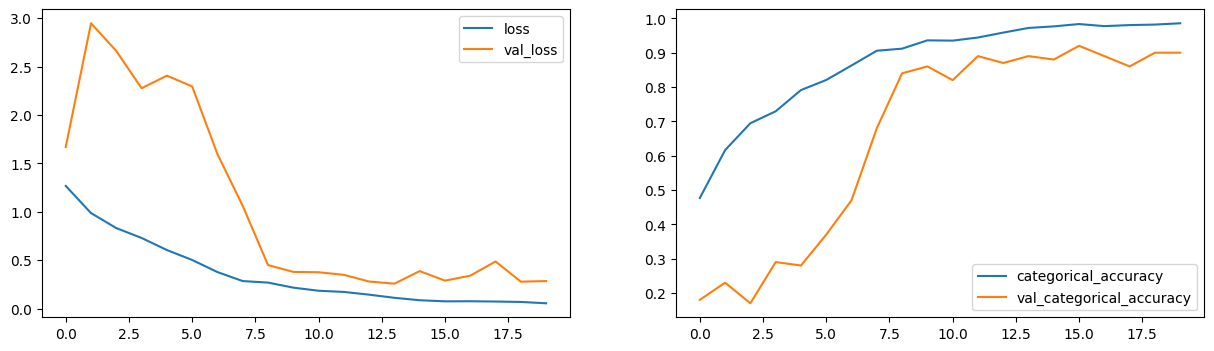

In [ ]:
plot(history_model6)

#### Interpretation of model 6

The performance of **Model 6** at **Epoch 20** is as follows:

- **Training Loss**: 0.0552
- **Training Categorical Accuracy**: 0.9857
- **Validation Loss**: 0.2848
- **Validation Categorical Accuracy**: 0.9000

Here's what we can infer from these metrics:

1. **Training Performance**:
   - The model achieves a very low training loss (0.0552), indicating that it fits the training data well.
   - The training categorical accuracy is high (98.57%), suggesting that the model correctly classifies most training samples.

2. **Validation Performance**:
   - The validation loss (0.2848) is slightly higher than the training loss, which is expected.
   - The validation categorical accuracy (90%) is also quite good, but not as high as the training accuracy.
   - This indicates that the model generalizes well to unseen data (validation set).


**Observation**:
The model seems to be overfitting because the training loss is significantly lower than the validation loss and could be helped using a regulariation technique.

# ModelBuilder with Augmentation:

Data augmentation is a technique used to increase the diversity of your training set by applying random (but realistic) transformations such as image rotation. This can help improve model performance, especially when the original dataset is small.

The generator method has an additional augment parameter. If augment is set to True, the generator will create augmented data for each batch.

The one_batch_data method also has an augment parameter. If augment is set to True, the method will create augmented versions of each image in the batch.

The augmentation process includes random shifting and rotation of the images.

The train_model method has an augment_data parameter. If augment_data is set to True, the training generator will create augmented data.

Since dropping layer was not a great regularization technique. Augmentation is another option and to be precise, we are using geometric transformated augumentation technique. We will then apply this to following models with positive outcomes.
- model 3
- model 5
- model 6

In [33]:
def save_metrics_to_csv(times, history, filepaths, csv_filename='training_metrics.csv'):
      df = pd.DataFrame({
          'epoch': range(1, len(times) + 1),
          'time': times,
          'categorical_accuracy': history.history['categorical_accuracy'],
          'val_categorical_accuracy': history.history['val_categorical_accuracy'],
          'loss': history.history['loss'],
          'val_loss': history.history['val_loss'],
          'filepath': filepaths
      })

In [61]:
class ModelBuilderAddAugmentation(metaclass= abc.ABCMeta):

    def initialize_path(self,project_folder):
        self.train_doc = np.random.permutation(open(project_folder + '/' + 'train.csv').readlines())
        self.val_doc = np.random.permutation(open(project_folder + '/' + 'val.csv').readlines())
        self.train_path = project_folder + '/' + 'train'
        self.val_path =  project_folder + '/' + 'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)

    def initialize_image_properties(self,image_height=100,image_width=100):
        self.image_height=image_height
        self.image_width=image_width
        self.channels=3
        self.num_classes=5
        self.total_frames=30

    def initialize_hyperparams(self,frames_to_sample=30,batch_size=20,num_epochs=20):
        self.frames_to_sample=frames_to_sample
        self.batch_size=batch_size
        self.num_epochs=num_epochs


    def generator(self,source_path, folder_list, augment=False):
        img_idx = np.round(np.linspace(0,self.total_frames-1,self.frames_to_sample)).astype(int)
        batch_size=self.batch_size
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t)//batch_size

            for batch in range(num_batches):
                batch_data, batch_labels= self.one_batch_data(source_path,t,batch,batch_size,img_idx,augment)
                yield batch_data, batch_labels

            remaining_seq=len(t)%batch_size

            if (remaining_seq != 0):
                batch_data, batch_labels= self.one_batch_data(source_path,t,num_batches,batch_size,img_idx,augment,remaining_seq)
                yield batch_data, batch_labels

    def one_batch_data(self,source_path,t,batch,batch_size,img_idx,augment,remaining_seq=0):

        seq_len = remaining_seq if remaining_seq else batch_size

        batch_data = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))
        batch_labels = np.zeros((seq_len,self.num_classes))

        if (augment): batch_data_aug = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))


        for folder in range(seq_len):
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0])
            for idx,item in enumerate(img_idx):
                image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                image_resized=resize(image,(self.image_height,self.image_width,3))


                batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255

                if (augment):
                    shifted = cv2.warpAffine(image,
                                             np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]),
                                            (image.shape[1], image.shape[0]))

                    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0)

                    cropped=shifted[x0:x1,y0:y1,:]

                    image_resized=resize(image,(self.image_height,self.image_width,3))


                    M = cv2.getRotationMatrix2D((self.image_width//2,self.image_height//2),
                                                np.random.randint(-10,10), 1.0)
                    rotated = cv2.warpAffine(image_resized, M, (self.image_width, self.image_height))

                    batch_data_aug[folder,idx,:,:,0] = (rotated[:,:,0])/255
                    batch_data_aug[folder,idx,:,:,1] = (rotated[:,:,1])/255
                    batch_data_aug[folder,idx,:,:,2] = (rotated[:,:,2])/255


            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1


        if (augment):
            batch_data=np.concatenate([batch_data,batch_data_aug])
            batch_labels=np.concatenate([batch_labels,batch_labels])


        return(batch_data,batch_labels)


    def train_model(self, model, augment_data=False):
        train_generator = self.generator(self.train_path, self.train_doc,augment=augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)

        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'

        if not os.path.exists(model_name):
            os.mkdir(model_name)


        # Define your learning rate scheduler
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        # filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        # checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')
        # LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        # callbacks_list = [checkpoint, LR]

        time_callback = TimeHistory()
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'
        checkpoint = CustomModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')
        callbacks_list = [checkpoint, LR, time_callback]

        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1

        history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1,
                            callbacks=callbacks_list, validation_data=val_generator,
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        times = time_callback.times  # This will be a list of times taken for each epoch
        filepaths = checkpoint.filepaths  # This will be a list of file paths used in the checkpoint
        # After model.fit_generator
        # save_metrics_to_csv(times, history, filepaths, 'training_metrics.csv')
        return history



        @abc.abstractmethod
        def define_model(self):
            pass

In [63]:
if 'history' in locals():
    print("The 'history' variable is available in local scope.")
else:
    print("The 'history' variable is not available in local scope.")

The 'history' variable is not available in local scope.


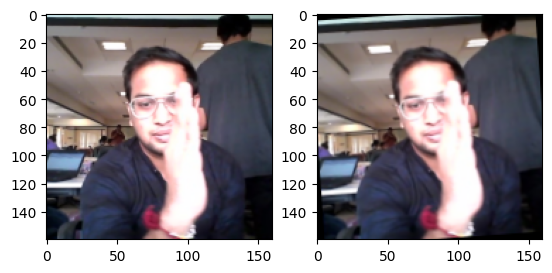

In [24]:
##testing the new model

class Test(ModelBuilderAddAugmentation):
    def define_model(self):
        pass

test_generator=Test()
test_generator.initialize_path(project_folder)
test_generator.initialize_image_properties(image_height=160,image_width=160)
test_generator.initialize_hyperparams(frames_to_sample=30,batch_size=3,num_epochs=1)

g=test_generator.generator(test_generator.val_path,test_generator.val_doc,augment=True)
batch_data, batch_labels=next(g)
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(batch_data[0,29,:,:,:])
axes[1].imshow(batch_data[3,29,:,:,:])

## Model 7 - Extension of Model 3 with Augumentation
- Inherits from: `ModelBuilderAddAugmentation`
- Method: `define_model`
    - Parameters:
        - `filtersize`: (3,3,3)
        - `dense_neurons`: 64
        - `dropout`: 0.25
- Layer construction:
    - Input Layer
    - Conv3D Layer 1: 16 filters
    - Activation: ReLU
    - BatchNormalization
    - MaxPooling3D Layer 1
    - Conv3D Layer 2: 32 filters
    - Activation: ReLU
    - BatchNormalization
    - MaxPooling3D Layer 2
    - Conv3D Layer 3: 64 filters
    - Activation: ReLU
    - BatchNormalization
    - MaxPooling3D Layer 3
    - Conv3D Layer 4: 128 filters
    - Activation: ReLU
    - BatchNormalization
    - MaxPooling3D Layer 4
    - Flatten Layer
    - Dense Layer 1: 256 neurons
    - BatchNormalization
    - Dropout Layer 1: 0.5 dropout
    - Dense Layer 2: 256 neurons
    - BatchNormalization
    - Dropout Layer 2: 0.5 dropout
    - Output Layer: Softmax activation
- Optimizer: Adam with learning rate 0.0003
- Loss function: Categorical Crossentropy
- Metrics: Categorical Accuracy

Model Initialization:
- Image properties: Height = 100, Width = 100
- Hyperparameters: Frames to sample = 15, Batch size = 10, Number of epochs = 30

In [16]:
class ModelConv3D7(ModelBuilderAddAugmentation):

    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2),padding='same'))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2),padding='same'))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0003)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

NameError: name 'ModelBuilderAddAugmentation' is not defined

In [ ]:
conv_3d7=ModelConv3D7()
conv_3d7.initialize_path(project_folder)
conv_3d7.initialize_image_properties(image_height=100,image_width=100)
conv_3d7.initialize_hyperparams(frames_to_sample=15,batch_size=10,num_epochs=30)
conv_3d7_model=conv_3d3.define_model(filtersize=(2,2,2),dense_neurons=256,dropout=0.5)
conv_3d7_model.summary()

Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_182 (Conv3D)         (None, 15, 100, 100, 16)  400       
                                                                 
 activation_182 (Activation)  (None, 15, 100, 100, 16)  0        
                                                                 
 batch_normalization_201 (Ba  (None, 15, 100, 100, 16)  64       
 tchNormalization)                                               
                                                                 
 max_pooling3d_161 (MaxPooli  (None, 8, 50, 50, 16)    0         
 ng3D)                                                           
                                                                 
 conv3d_183 (Conv3D)         (None, 8, 50, 50, 32)     4128      
                                                                 
 activation_183 (Activation)  (None, 8, 50, 50, 32)  

In [ ]:
print("Total Params:", conv_3d7_model.count_params())
history_model7=conv_3d7.train_model(conv_3d7_model,augment_data=True)


Total Params: 1336629
Epoch 1/30
67/67 [==============================] - ETA: 0s - loss: 1.8537 - categorical_accuracy: 0.3952
Epoch 1: saving model to model_init_2024-04-0917_49_40.441775\model-00001-1.85368-0.39517-2.74263-0.16000.h5
67/67 [==============================] - 140s 2s/step - loss: 1.8537 - categorical_accuracy: 0.3952 - val_loss: 2.7426 - val_categorical_accuracy: 0.1600 - lr: 3.0000e-04
Epoch 2/30
67/67 [==============================] - ETA: 0s - loss: 1.3077 - categorical_accuracy: 0.5566
Epoch 2: saving model to model_init_2024-04-0917_49_40.441775\model-00002-1.30765-0.55656-4.44864-0.15000.h5
67/67 [==============================] - 122s 2s/step - loss: 1.3077 - categorical_accuracy: 0.5566 - val_loss: 4.4486 - val_categorical_accuracy: 0.1500 - lr: 3.0000e-04
Epoch 3/30
67/67 [==============================] - ETA: 0s - loss: 1.0067 - categorical_accuracy: 0.6501
Epoch 3: saving model to model_init_2024-04-0917_49_40.441775\model-00003-1.00671-0.65008-5.33253-0.

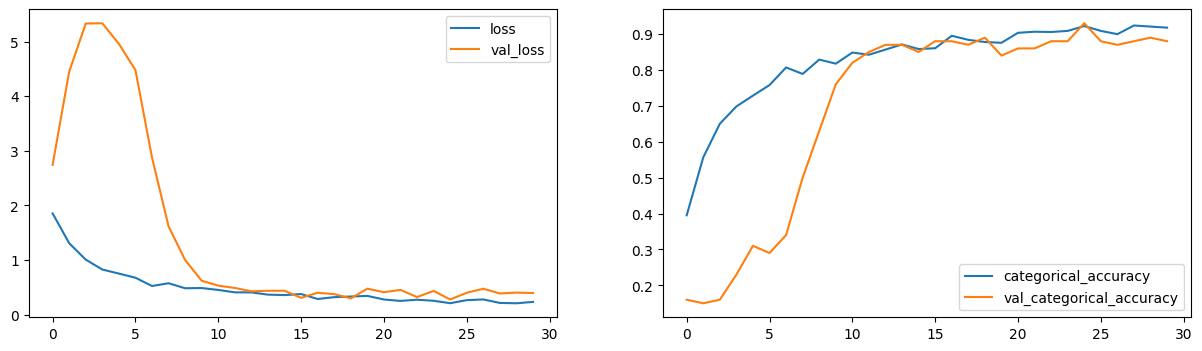

In [ ]:
plot(history_model7)

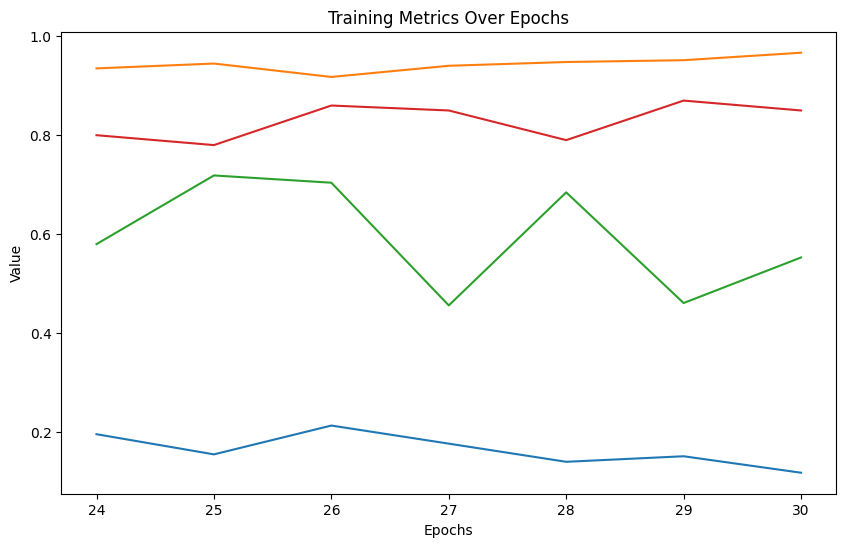

In [65]:
import matplotlib.pyplot as plt

# Data
epochs = [24, 25, 26, 27, 28, 29, 30]
loss = [0.1953, 0.1545, 0.2128, 0.1762, 0.1395, 0.1507, 0.1174]
categorical_accuracy = [0.9351, 0.9449, 0.9178, 0.9404, 0.9480, 0.9517, 0.9668]
val_loss = [0.5797, 0.7186, 0.7039, 0.4558, 0.6844, 0.4606, 0.5527]
val_categorical_accuracy = [0.8, 0.78, 0.86, 0.85, 0.79, 0.87, 0.85]

# Plotting
plt.figure(figsize=(10, 6))

plt.plot(epochs, loss, label='loss')
plt.plot(epochs, categorical_accuracy, label='categorical_accuracy')
plt.plot(epochs, val_loss, label='val_loss')
plt.plot(epochs, val_categorical_accuracy, label='val_categorical_accuracy')

plt.title('Training Metrics Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Value')


plt.show()

#### Interpreation of Model 7

Loss Graph (Left):
Initially, the loss is high, but as the training progresses, the loss gradually decreases, signifying improvement.
The downward trend suggests that the model is learning and adjusting its parameters.

Accuracy Graph (Right):
Initially, accuracy is low, as expected. However, it steadily increases with each epoch.
The upward trend indicates that the model is becoming more accurate in its predictions.
In summary, both graphs demonstrate the model’s journey from initial learning stages (high loss, low accuracy) to optimized performance (low loss, high accuracy). It’s a the learning pattern we are looking for.

## Model 7 - Extension of Model 3 with Augumentation - Rerun
- Inherits from: `ModelBuilderAddAugmentation`
- Method: `define_model`
    - Parameters:
        - `filtersize`: (3,3,3)
        - `dense_neurons`: 64
        - `dropout`: 0.25
- Layer construction:
    - Input Layer
    - Conv3D Layer 1: 16 filters
    - Activation: ReLU
    - BatchNormalization
    - MaxPooling3D Layer 1
    - Conv3D Layer 2: 32 filters
    - Activation: ReLU
    - BatchNormalization
    - MaxPooling3D Layer 2
    - Conv3D Layer 3: 64 filters
    - Activation: ReLU
    - BatchNormalization
    - MaxPooling3D Layer 3
    - Conv3D Layer 4: 128 filters
    - Activation: ReLU
    - BatchNormalization
    - MaxPooling3D Layer 4
    - Flatten Layer
    - Dense Layer 1: 256 neurons
    - BatchNormalization
    - Dropout Layer 1: 0.5 dropout
    - Dense Layer 2: 256 neurons
    - BatchNormalization
    - Dropout Layer 2: 0.5 dropout
    - Output Layer: Softmax activation
- Optimizer: Adam with learning rate 0.0003
- Loss function: Categorical Crossentropy
- Metrics: Categorical Accuracy

Model Initialization:
- Image properties: Height = 100, Width = 100
- Hyperparameters: Frames to sample = 15, Batch size = 10, Number of epochs = 30

In [39]:
class ModelConv3D7(ModelBuilderAddAugmentation):

    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2),padding='same'))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2),padding='same'))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0003)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [40]:
conv_3d7_f=ModelConv3D7()
conv_3d7_f.initialize_path(project_folder)
conv_3d7_f.initialize_image_properties(image_height=100,image_width=100)
conv_3d7_f.initialize_hyperparams(frames_to_sample=15,batch_size=10,num_epochs=30)
conv_3d7_model_f=conv_3d3.define_model(filtersize=(2,2,2),dense_neurons=256,dropout=0.5)
conv_3d7_model_f.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_16 (Conv3D)          (None, 15, 100, 100, 16   400       
                             )                                   
                                                                 
 activation_16 (Activation)  (None, 15, 100, 100, 16   0         
                             )                                   
                                                                 
 batch_normalization_24 (Ba  (None, 15, 100, 100, 16   64        
 tchNormalization)           )                                   
                                                                 
 max_pooling3d_16 (MaxPooli  (None, 8, 50, 50, 16)     0         
 ng3D)                                                           
                                                                 
 conv3d_17 (Conv3D)          (None, 8, 50, 50, 32)    

In [43]:
print("Total Params:", conv_3d7_model_f.count_params())
history_model7_f=conv_3d7_f.train_model(conv_3d7_model_f,augment_data=True)

Total Params: 1336629
Epoch 1/30
67/67 [==============================] - ETA: 0s - loss: 1.9794 - categorical_accuracy: 0.3944
Epoch 1: saving model to model_init_2024-04-1519_28_51.499398/model-00001-1.97939-0.39442-7.03333-0.16000.h5
67/67 [==============================] - 155s 2s/step - loss: 1.9794 - categorical_accuracy: 0.3944 - val_loss: 7.0333 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/30
67/67 [==============================] - ETA: 0s - loss: 1.5140 - categorical_accuracy: 0.4698
Epoch 2: saving model to model_init_2024-04-1519_28_51.499398/model-00002-1.51397-0.46983-8.71504-0.17000.h5
67/67 [==============================] - 144s 2s/step - loss: 1.5140 - categorical_accuracy: 0.4698 - val_loss: 8.7150 - val_categorical_accuracy: 0.1700 - lr: 0.0010
Epoch 3/30
67/67 [==============================] - ETA: 0s - loss: 1.2546 - categorical_accuracy: 0.5603
Epoch 3: saving model to model_init_2024-04-1519_28_51.499398/model-00003-1.25464-0.56033-12.56995-0.14000.h

NameError: name 'pd' is not defined

In [44]:
plot(history_model7_f)

NameError: name 'history_model7_f' is not defined

#### Interpreation of Model 7 - Rerun

Loss Graph (Left):
Initially, the loss is high, but as the training progresses, the loss gradually decreases, signifying improvement.
The downward trend suggests that the model is learning and adjusting its parameters.

Accuracy Graph (Right):
Initially, accuracy is low, as expected. However, it steadily increases with each epoch.
The upward trend indicates that the model is becoming more accurate in its predictions.
In summary, both graphs demonstrate the model’s journey from initial learning stages (high loss, low accuracy) to optimized performance (low loss, high accuracy). It’s a the learning pattern we are looking for.

## Model 8 - Extension of Model 5 with Augumentation

- Inherits from: `ModelBuilderAddAugmentation`
- Method: `define_model`
    - Parameters:
        - `filtersize`: (3,3,3)
        - `dense_neurons`: 64
        - `dropout`: 0.25
- Layer construction:
    - Input Layer
    - Conv3D Layer 1: 8 filters
    - Activation: ReLU
    - BatchNormalization
    - MaxPooling3D Layer 1
    - Conv3D Layer 2: 16 filters
    - Activation: ReLU
    - BatchNormalization
    - MaxPooling3D Layer 2 (if output shape > 1)
    - Conv3D Layer 3: 32 filters
    - Activation: ReLU
    - BatchNormalization
    - MaxPooling3D Layer 3 (if output shape > 1)
    - Conv3D Layer 4: 64 filters
    - Activation: ReLU
    - BatchNormalization
    - MaxPooling3D Layer 4 (if output shape > 1)
    - Conv3D Layer 5: 128 filters
    - Activation: ReLU
    - BatchNormalization
    - MaxPooling3D Layer 5 (if output shape > 1)
    - Flatten Layer
    - Dense Layer 1: 32 neurons
    - BatchNormalization
    - Dropout Layer 1: 0.25 dropout
    - Dense Layer 2: 32 neurons
    - BatchNormalization
    - Dropout Layer 2: 0.25 dropout
    - Output Layer: Softmax activation
- Optimizer: Adam with learning rate 0.0003
- Loss function: Categorical Crossentropy
- Metrics: Categorical Accuracy

Model Initialization:
- Image properties: Height = 100, Width = 100
- Hyperparameters: Frames to sample = 15, Batch size = 10, Number of epochs = 22

In [ ]:
class ModelConv3D8(ModelBuilderAddAugmentation):
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(8, filtersize, padding='same', input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(16, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        if model.output_shape[1] > 1:
            model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        if model.output_shape[1] > 1:
            model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        if model.output_shape[1] > 1:
            model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        if model.output_shape[1] > 1:
            model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0003)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
conv_3d8=ModelConv3D8()
conv_3d8.initialize_path(project_folder)
conv_3d8.initialize_image_properties(image_height=100,image_width=100)
conv_3d8.initialize_hyperparams(frames_to_sample=15,batch_size=10,num_epochs=22)
conv_3d8_model=conv_3d8.define_model(dense_neurons=32,dropout=0.25)
conv_3d8_model.summary()

Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_186 (Conv3D)         (None, 15, 100, 100, 8)   656       
                                                                 
 activation_186 (Activation)  (None, 15, 100, 100, 8)  0         
                                                                 
 batch_normalization_207 (Ba  (None, 15, 100, 100, 8)  32        
 tchNormalization)                                               
                                                                 
 max_pooling3d_165 (MaxPooli  (None, 7, 50, 50, 8)     0         
 ng3D)                                                           
                                                                 
 conv3d_187 (Conv3D)         (None, 7, 50, 50, 16)     3472      
                                                                 
 activation_187 (Activation)  (None, 7, 50, 50, 16)  

In [ ]:
print("Total Params:", conv_3d8_model.count_params())
history_model8=conv_3d8.train_model(conv_3d8_model,augment_data=True)

Total Params: 444613
Epoch 1/22
67/67 [==============================] - ETA: 0s - loss: 0.6791 - categorical_accuracy: 0.7489
Epoch 1: saving model to model_init_2024-04-0923_19_45.742255\model-00001-0.67911-0.74887-1.56547-0.47000.h5
67/67 [==============================] - 124s 2s/step - loss: 0.6791 - categorical_accuracy: 0.7489 - val_loss: 1.5655 - val_categorical_accuracy: 0.4700 - lr: 6.0000e-05
Epoch 2/22
67/67 [==============================] - ETA: 0s - loss: 0.6472 - categorical_accuracy: 0.7730
Epoch 2: saving model to model_init_2024-04-0923_19_45.742255\model-00002-0.64721-0.77300-1.14105-0.56000.h5
67/67 [==============================] - 110s 2s/step - loss: 0.6472 - categorical_accuracy: 0.7730 - val_loss: 1.1411 - val_categorical_accuracy: 0.5600 - lr: 6.0000e-05
Epoch 3/22
67/67 [==============================] - ETA: 0s - loss: 0.6092 - categorical_accuracy: 0.7805
Epoch 3: saving model to model_init_2024-04-0923_19_45.742255\model-00003-0.60920-0.78054-0.80794-0.7

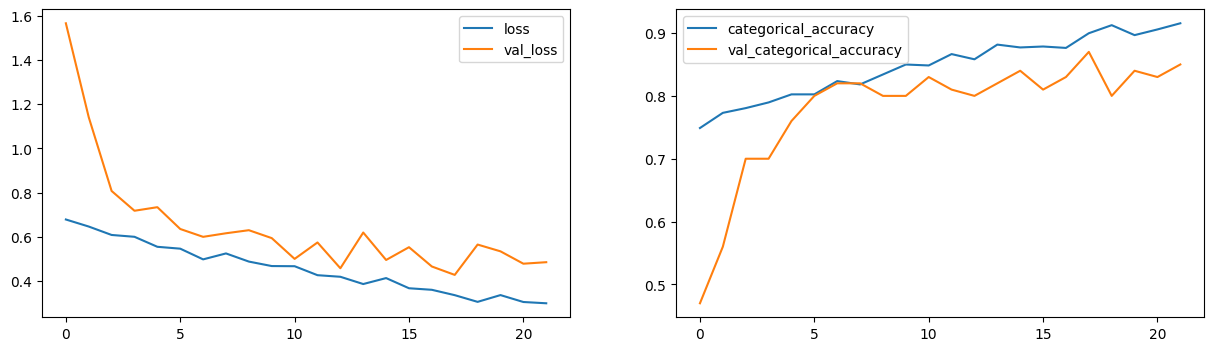

In [ ]:
plot(history_model8)

#### Interpreation of Model 8


Loss Graph (Left):
Initially, the loss is high, but as the training progresses, the loss gradually decreases, signifying improvement.
The downward trend suggests that the model is learning and adjusting its parameters.

Accuracy Graph (Right):
val_categorical_accuracy is less than Model 7

## Model 9 - Extension of Model 6 with Augumentation

- Inherits from: `ModelBuilderAddAugmentation`
- Method: `define_model`
    - Parameters:
        - `lstm_cells`: 64
        - `dense_neurons`: 64
        - `dropout`: 0.25
- Layer construction:
    - TimeDistributed Layer 1: Conv2D with 16 filters
    - Activation: ReLU
    - BatchNormalization
    - MaxPooling2D
    - TimeDistributed Layer 2: Conv2D with 32 filters
    - Activation: ReLU
    - BatchNormalization
    - MaxPooling2D
    - TimeDistributed Layer 3: Conv2D with 64 filters
    - Activation: ReLU
    - BatchNormalization
    - MaxPooling2D
    - TimeDistributed Layer 4: Conv2D with 128 filters
    - Activation: ReLU
    - BatchNormalization
    - MaxPooling2D
    - TimeDistributed Layer 5: Conv2D with 256 filters
    - Activation: ReLU
    - BatchNormalization
    - MaxPooling2D
    - TimeDistributed Flatten Layer
    - LSTM Layer: 128 cells
    - Dropout Layer 1: 0.25 dropout
    - Dense Layer 1: 128 neurons
    - Dropout Layer 2: 0.25 dropout
    - Output Layer: Softmax activation
- Optimizer: Adam
- Loss function: Categorical Crossentropy
- Metrics: Categorical Accuracy

Model Initialization:
- Image properties: Height = 100, Width = 100
- Hyperparameters: Frames to sample = 15, Batch size = 5, Number of epochs = 20

In [ ]:
class RNNCNN2(ModelBuilderAddAugmentation):
  def define_model(self,lstm_cells=64, dense_neurons=64, dropout=0.25):
      model = Sequential()
      model.add(TimeDistributed(Conv2D(16, (3,3), padding='same', activation='relu'),
                                input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
      model.add(TimeDistributed(BatchNormalization()))
      model.add(TimeDistributed(MaxPooling2D((2,2))))

      model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
      model.add(TimeDistributed(BatchNormalization()))
      model.add(TimeDistributed(MaxPooling2D((2, 2))))

      model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
      model.add(TimeDistributed(BatchNormalization()))
      model.add(TimeDistributed(MaxPooling2D((2, 2))))

      model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
      model.add(TimeDistributed(BatchNormalization()))
      model.add(TimeDistributed(MaxPooling2D((2, 2))))

      model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
      model.add(TimeDistributed(BatchNormalization()))
      model.add(TimeDistributed(MaxPooling2D((2, 2))))

      model.add(TimeDistributed(Flatten()))

      model.add(LSTM(lstm_cells))
      model.add(Dropout(dropout))

      model.add(Dense(dense_neurons,activation='relu'))
      model.add(Dropout(dropout))

      model.add(Dense(self.num_classes, activation='softmax'))
      optimiser = optimizers.Adam()
      model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
      return model

In [ ]:
rnn_cnn2=RNNCNN2()
rnn_cnn2.initialize_path(project_folder)
rnn_cnn2.initialize_image_properties(image_height=100,image_width=100)
rnn_cnn2.initialize_hyperparams(frames_to_sample=15,batch_size=5,num_epochs=20)
rnn_cnn2_model=rnn_cnn2.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn2_model.summary()

Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_32 (TimeDi  (None, 15, 100, 100, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_33 (TimeDi  (None, 15, 100, 100, 16)  64       
 stributed)                                                      
                                                                 
 time_distributed_34 (TimeDi  (None, 15, 50, 50, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_35 (TimeDi  (None, 15, 50, 50, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_36 (TimeDi  (None, 15, 50, 50, 32) 

In [ ]:
print("Total params:", rnn_cnn2_model.count_params())
history_model9=rnn_cnn2.train_model(rnn_cnn2_model, augment_data=True)

Total params: 1657445
Epoch 1/20
133/133 [==============================] - ETA: 0s - loss: 1.4293 - categorical_accuracy: 0.3876
Epoch 1: saving model to model_init_2024-04-1011_45_01.550917\model-00001-1.42932-0.38763-1.86766-0.21000.h5
133/133 [==============================] - 133s 956ms/step - loss: 1.4293 - categorical_accuracy: 0.3876 - val_loss: 1.8677 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/20
133/133 [==============================] - ETA: 0s - loss: 1.1127 - categorical_accuracy: 0.5649
Epoch 2: saving model to model_init_2024-04-1011_45_01.550917\model-00002-1.11266-0.56486-2.45281-0.27000.h5
133/133 [==============================] - 106s 799ms/step - loss: 1.1127 - categorical_accuracy: 0.5649 - val_loss: 2.4528 - val_categorical_accuracy: 0.2700 - lr: 0.0010
Epoch 3/20
133/133 [==============================] - ETA: 0s - loss: 0.9644 - categorical_accuracy: 0.6425
Epoch 3: saving model to model_init_2024-04-1011_45_01.550917\model-00003-0.96444-0.64253-1.

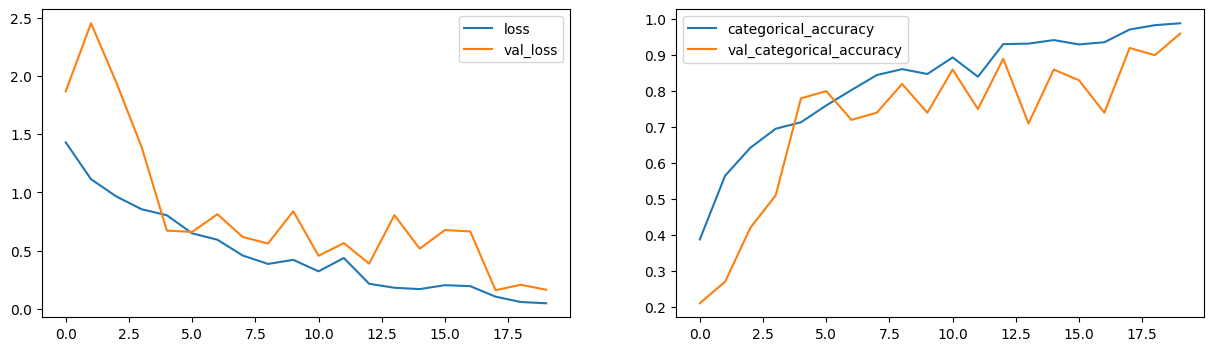

In [ ]:
plot(history_model9)

#### Interpreation of Model 9

Loss Graph (Left):
More val_loss than loss

Accuracy Graph (Right):
good gap between categorical_accuracy and val_categorical_accuracy

## Model 10
- Inherits from: `ModelBuilderAddAugmentation`
- Method: `define_model`
    - Parameters:
        - `lstm_cells`: 64
        - `dense_neurons`: 64
        - `dropout`: 0.25
- Layer construction:
    - TimeDistributed Layer 1: Conv2D with 16 filters
    - Activation: ReLU
    - BatchNormalization
    - MaxPooling2D
    - TimeDistributed Layer 2: Conv2D with 32 filters
    - Activation: ReLU
    - BatchNormalization
    - MaxPooling2D
    - TimeDistributed Layer 3: Conv2D with 64 filters
    - Activation: ReLU
    - BatchNormalization
    - MaxPooling2D
    - TimeDistributed Layer 4: Conv2D with 128 filters
    - Activation: ReLU
    - BatchNormalization
    - MaxPooling2D
    - TimeDistributed Flatten Layer
    - GRU Layer: 128 cells
    - Dropout Layer 1: 0.25 dropout
    - Dense Layer 1: 128 neurons
    - Dropout Layer 2: 0.25 dropout
    - Output Layer: Softmax activation
- Optimizer: Adam with learning rate 0.0002
- Loss function: Categorical Crossentropy
- Metrics: Categorical Accuracy

Model Initialization:
- Image properties: Height = 100, Width = 100
- Hyperparameters: Frames to sample = 15, Batch size = 10, Number of epochs = 20

Using GRU instead of LSTM since the LSTM is computationally expensive and complex. GRU has fewer parameters, less prone to overfitting and faster computation.


In [ ]:
class RNNCNN3(ModelBuilderAddAugmentation):

    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))


        model.add(TimeDistributed(Flatten()))


        model.add(GRU(lstm_cells))
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes, activation='softmax'))
        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
rnn_cnn3=RNNCNN3()
rnn_cnn3.initialize_path(project_folder)
rnn_cnn3.initialize_image_properties(image_height=100,image_width=100)
rnn_cnn3.initialize_hyperparams(frames_to_sample=15,batch_size=10,num_epochs=20)
rnn_cnn3_model=rnn_cnn2.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn3_model.summary()

Model: "sequential_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_48 (TimeDi  (None, 15, 100, 100, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_49 (TimeDi  (None, 15, 100, 100, 16)  64       
 stributed)                                                      
                                                                 
 time_distributed_50 (TimeDi  (None, 15, 50, 50, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_51 (TimeDi  (None, 15, 50, 50, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_52 (TimeDi  (None, 15, 50, 50, 32) 

In [ ]:
print("Total Params:", rnn_cnn3_model.count_params())
history_model10=rnn_cnn3.train_model(rnn_cnn3_model,augment_data=True)


Total Params: 1657445
Epoch 1/20
67/67 [==============================] - ETA: 0s - loss: 1.3242 - categorical_accuracy: 0.4510
Epoch 1: saving model to model_init_2024-04-1015_19_48.290761\model-00001-1.32422-0.45098-1.77400-0.16000.h5
67/67 [==============================] - 127s 2s/step - loss: 1.3242 - categorical_accuracy: 0.4510 - val_loss: 1.7740 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/20
67/67 [==============================] - ETA: 0s - loss: 0.9854 - categorical_accuracy: 0.6214
Epoch 2: saving model to model_init_2024-04-1015_19_48.290761\model-00002-0.98539-0.62142-2.30295-0.18000.h5
67/67 [==============================] - 107s 2s/step - loss: 0.9854 - categorical_accuracy: 0.6214 - val_loss: 2.3030 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 3/20
67/67 [==============================] - ETA: 0s - loss: 0.7632 - categorical_accuracy: 0.7104
Epoch 3: saving model to model_init_2024-04-1015_19_48.290761\model-00003-0.76315-0.71041-2.37694-0.24000.h5

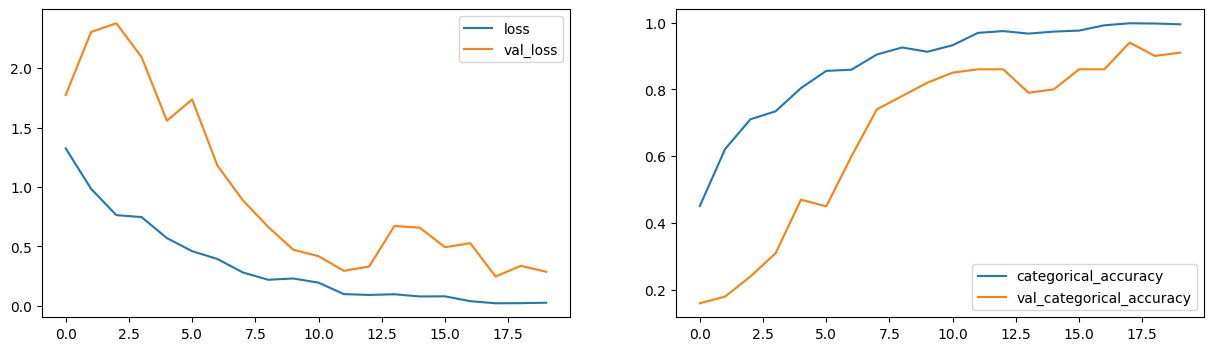

In [ ]:
plot(history_model10)


#### Interpreation of Model 10

Loss Graph (Left):
More val_loss than loss

Accuracy Graph (Right):
More gap between categorical_accuracy and val_categorical_accuracy

## Model 11: Transfer Learning

In [ ]:
from keras.applications import mobilenet

mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

class RNNCNN_TL(ModelBuilderAddAugmentation):

    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(TimeDistributed(mobilenet_transfer,input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))


        for layer in model.layers:
            layer.trainable = False


        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(LSTM(lstm_cells))
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes, activation='softmax'))


        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
rnn_cnn_tl=RNNCNN_TL()
rnn_cnn_tl.initialize_path(project_folder)
rnn_cnn_tl.initialize_image_properties(image_height=100,image_width=100)
rnn_cnn_tl.initialize_hyperparams(frames_to_sample=15,batch_size=5,num_epochs=20)
rnn_cnn_tl_model=rnn_cnn_tl.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn_tl_model.summary()

Model: "sequential_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_64 (TimeDi  (None, 15, 3, 3, 1024)   3228864   
 stributed)                                                      
                                                                 
 time_distributed_65 (TimeDi  (None, 15, 3, 3, 1024)   4096      
 stributed)                                                      
                                                                 
 time_distributed_66 (TimeDi  (None, 15, 1, 1, 1024)   0         
 stributed)                                                      
                                                                 
 time_distributed_67 (TimeDi  (None, 15, 1024)         0         
 stributed)                                                      
                                                                 
 lstm_4 (LSTM)               (None, 128)             

In [ ]:
print("Total Params:", rnn_cnn_tl_model.count_params())
history_model11=rnn_cnn_tl.train_model(rnn_cnn_tl_model,augment_data=True)


Total Params: 3840453
Epoch 1/20
133/133 [==============================] - ETA: 0s - loss: 1.2705 - categorical_accuracy: 0.4789
Epoch 1: saving model to model_init_2024-04-1016_24_18.732926\model-00001-1.27051-0.47888-0.83856-0.72000.h5
133/133 [==============================] - 129s 957ms/step - loss: 1.2705 - categorical_accuracy: 0.4789 - val_loss: 0.8386 - val_categorical_accuracy: 0.7200 - lr: 0.0010
Epoch 2/20
133/133 [==============================] - ETA: 0s - loss: 0.6891 - categorical_accuracy: 0.7496
Epoch 2: saving model to model_init_2024-04-1016_24_18.732926\model-00002-0.68908-0.74962-0.61206-0.83000.h5
133/133 [==============================] - 122s 925ms/step - loss: 0.6891 - categorical_accuracy: 0.7496 - val_loss: 0.6121 - val_categorical_accuracy: 0.8300 - lr: 0.0010
Epoch 3/20
133/133 [==============================] - ETA: 0s - loss: 0.4451 - categorical_accuracy: 0.8394
Epoch 3: saving model to model_init_2024-04-1016_24_18.732926\model-00003-0.44506-0.83937-0.

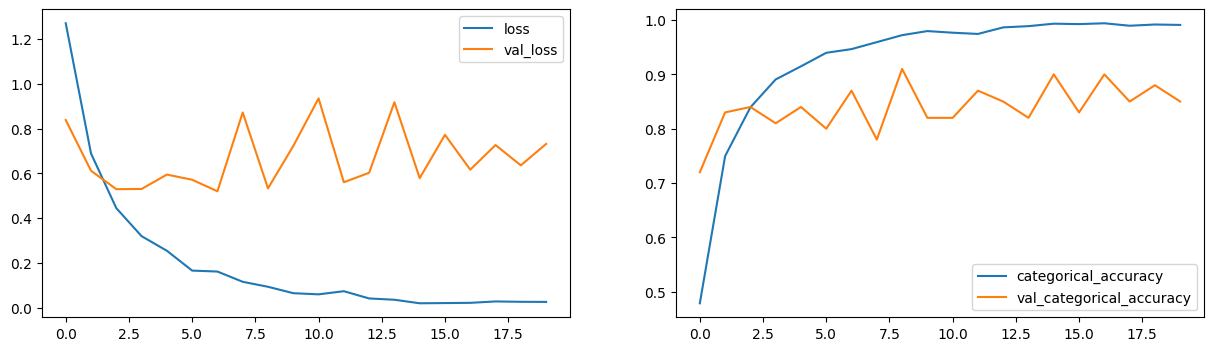

In [ ]:
plot(history_model11)


#### Interpreation of Model 11

Loss Graph (Left):
`val_loss` very High

Accuracy Graph (Right):
Huge gap between categorical_accuracy and val_categorical_accuracy

## Model 12 - Transfer Learning with GRU and training all weights

In [ ]:
from keras.applications import mobilenet

mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

class RNNCNN_TL2(ModelBuilderAddAugmentation):

    def define_model(self,gru_cells=64,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(TimeDistributed(mobilenet_transfer,input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))

        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(GRU(gru_cells))
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes, activation='softmax'))


        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
rnn_cnn_tl2=RNNCNN_TL2()
rnn_cnn_tl2.initialize_path(project_folder)
rnn_cnn_tl2.initialize_image_properties(image_height=100,image_width=100)
rnn_cnn_tl2.initialize_hyperparams(frames_to_sample=15,batch_size=3,num_epochs=20)
rnn_cnn_tl2_model=rnn_cnn_tl2.define_model(gru_cells=64,dense_neurons=128,dropout=0.25)
rnn_cnn_tl2_model.summary()

Model: "sequential_46"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_80 (TimeDi  (None, 15, 3, 3, 1024)   3228864   
 stributed)                                                      
                                                                 
 time_distributed_81 (TimeDi  (None, 15, 3, 3, 1024)   4096      
 stributed)                                                      
                                                                 
 time_distributed_82 (TimeDi  (None, 15, 1, 1, 1024)   0         
 stributed)                                                      
                                                                 
 time_distributed_83 (TimeDi  (None, 15, 1024)         0         
 stributed)                                                      
                                                                 
 gru_3 (GRU)                 (None, 64)              

In [ ]:
print("Total Params:", rnn_cnn_tl2_model.count_params())
history_model12=rnn_cnn_tl2.train_model(rnn_cnn_tl2_model,augment_data=True)
#temp

Total Params: 3451205
Epoch 1/20


ResourceExhaustedError: Graph execution error:

Detected at node 'sequential_46/time_distributed_80/mobilenet_1.00_224/conv_dw_9_bn/FusedBatchNormV3' defined at (most recent call last):
    File "C:\Users\writi\miniconda3\envs\tf\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\writi\miniconda3\envs\tf\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\Users\writi\miniconda3\envs\tf\lib\site-packages\ipykernel_launcher.py", line 18, in <module>
      app.launch_new_instance()
    File "C:\Users\writi\miniconda3\envs\tf\lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
      app.start()
    File "C:\Users\writi\miniconda3\envs\tf\lib\site-packages\ipykernel\kernelapp.py", line 739, in start
      self.io_loop.start()
    File "C:\Users\writi\miniconda3\envs\tf\lib\site-packages\tornado\platform\asyncio.py", line 205, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\writi\miniconda3\envs\tf\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "C:\Users\writi\miniconda3\envs\tf\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "C:\Users\writi\miniconda3\envs\tf\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\writi\miniconda3\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue
      await self.process_one()
    File "C:\Users\writi\miniconda3\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 534, in process_one
      await dispatch(*args)
    File "C:\Users\writi\miniconda3\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell
      await result
    File "C:\Users\writi\miniconda3\envs\tf\lib\site-packages\ipykernel\ipkernel.py", line 362, in execute_request
      await super().execute_request(stream, ident, parent)
    File "C:\Users\writi\miniconda3\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 778, in execute_request
      reply_content = await reply_content
    File "C:\Users\writi\miniconda3\envs\tf\lib\site-packages\ipykernel\ipkernel.py", line 449, in do_execute
      res = shell.run_cell(
    File "C:\Users\writi\miniconda3\envs\tf\lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\writi\miniconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3048, in run_cell
      result = self._run_cell(
    File "C:\Users\writi\miniconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3103, in _run_cell
      result = runner(coro)
    File "C:\Users\writi\miniconda3\envs\tf\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\writi\miniconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3308, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\writi\miniconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3490, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\writi\miniconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3550, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\writi\AppData\Local\Temp\ipykernel_13080\1741581906.py", line 2, in <module>
      history_model12=rnn_cnn_tl2.train_model(rnn_cnn_tl2_model,augment_data=True)
    File "C:\Users\writi\AppData\Local\Temp\ipykernel_13080\186386044.py", line 121, in train_model
      history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1,
    File "C:\Users\writi\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 2507, in fit_generator
      return self.fit(
    File "C:\Users\writi\miniconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\writi\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\writi\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "C:\Users\writi\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\writi\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "C:\Users\writi\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 993, in train_step
      y_pred = self(x, training=True)
    File "C:\Users\writi\miniconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\writi\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "C:\Users\writi\miniconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\writi\miniconda3\envs\tf\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\writi\miniconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\writi\miniconda3\envs\tf\lib\site-packages\keras\engine\sequential.py", line 410, in call
      return super().call(inputs, training=training, mask=mask)
    File "C:\Users\writi\miniconda3\envs\tf\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "C:\Users\writi\miniconda3\envs\tf\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\Users\writi\miniconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\writi\miniconda3\envs\tf\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\writi\miniconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\writi\miniconda3\envs\tf\lib\site-packages\keras\layers\rnn\time_distributed.py", line 252, in call
      y = self.layer(inputs, **kwargs)
    File "C:\Users\writi\miniconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\writi\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "C:\Users\writi\miniconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\writi\miniconda3\envs\tf\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\writi\miniconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\writi\miniconda3\envs\tf\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "C:\Users\writi\miniconda3\envs\tf\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\Users\writi\miniconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\writi\miniconda3\envs\tf\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\writi\miniconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\writi\miniconda3\envs\tf\lib\site-packages\keras\layers\normalization\batch_normalization.py", line 850, in call
      outputs = self._fused_batch_norm(inputs, training=training)
    File "C:\Users\writi\miniconda3\envs\tf\lib\site-packages\keras\layers\normalization\batch_normalization.py", line 660, in _fused_batch_norm
      output, mean, variance = control_flow_util.smart_cond(
    File "C:\Users\writi\miniconda3\envs\tf\lib\site-packages\keras\utils\control_flow_util.py", line 108, in smart_cond
      return tf.__internal__.smart_cond.smart_cond(
    File "C:\Users\writi\miniconda3\envs\tf\lib\site-packages\keras\layers\normalization\batch_normalization.py", line 634, in _fused_batch_norm_training
      return tf.compat.v1.nn.fused_batch_norm(
Node: 'sequential_46/time_distributed_80/mobilenet_1.00_224/conv_dw_9_bn/FusedBatchNormV3'
OOM when allocating tensor with shape[150,512,6,6] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node sequential_46/time_distributed_80/mobilenet_1.00_224/conv_dw_9_bn/FusedBatchNormV3}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_252746]

In [ ]:
plot(history_model12)


## Final Model Selection

## Validation

In [46]:
import time
from keras.models import load_model
model = load_model('/content/final_model/model-00025-0.20884-0.92232-0.27682-0.93000.h5')


In [53]:
final_model_budilder=ModelConv3D7()
final_model_budilder.initialize_path(project_folder)
final_model_budilder.initialize_image_properties(image_height=100,image_width=100)
final_model_budilder.initialize_hyperparams(frames_to_sample=15,batch_size=10,num_epochs=15)

In [54]:
#setting the augment=False
validation_generator = final_model_budilder.generator(final_model_budilder.val_path, final_model_budilder.val_doc, augment=False)

In [55]:
# getting the next batch data and labels for the validation generator
final_batch_data, final_batch_labels = next(validation_generator)

In [58]:
predictions = model.predict(final_batch_data)

1/1 [==============================] - 0s 37ms/step


In [60]:
from sklearn.metrics import accuracy_score

# Make predictions on the fetched batch of data using the trained model
predictions = model.predict(final_batch_data)

# Get the class with the highest probability for each sample
predicted_classes = np.argmax(predictions, axis=1)

# Get the true classes
true_classes = np.argmax(final_batch_labels, axis=1)

# Calculate the accuracy
accuracy = accuracy_score(true_classes, predicted_classes)

print(f'Final Accuracy on the Validation data: {accuracy}')

1/1 [==============================] - 0s 40ms/step
Final Accuracy on the Validation data: 0.9


## End of model building
### by Writika & Bharathan